In [431]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


Goal:
Clean survey dataset
- unify commata to decimals
- clean columns from typos
- define correct datatype to the columns
- select cols wich could be later needed for model development
- combine targets based on compared predictators


For reasons of reusability and comparability the workflow of the data preprocessing was kept similar to previous preprocessings of the same questionnaire. This was achieved by dealing with missing or erroneous values in a similar way likewise erroneous values with commas or points in the beginning were converted to decimal numbers beginning with zero. 

In [432]:
import sys, os
sys.path.insert(0,os.getcwd())

import numpy as np
import pandas as pd
import geopandas as gpd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from utils_processing import drop_object_columns, drop_typos

pd.set_option('display.max_columns', None)

In [433]:
# load raw survey data

raw_data = pd.read_excel("../input_survey_data/all-attributes_shophouses.xlsx")#, thousands=',')
raw_data.tail(3)

,Q0.1,Q0.2.Ward,Q0.2.District,Q0.3,Q0.4,Q0.5,Q0.6,Q0.7,Pre.Q1,Pre.Q2,P1Q1,P1Q1.specify,P1Q2.1.1,P1Q2.2.1,P1Q2.3.1,P1Q2.4.1,P1Q2.5.1.0,P1Q2.5.1.1,P1Q2.5.1.2,P1Q2.5.1.3,P1Q2.5.1.4,P1Q2.5.1.88,P1Q2.5.1.99,P1Q2.5.1.specify,P1Q2.6.1,P1Q2.7.1.1,P1Q2.7.1.2,P1Q2.7.1.3,P1Q2.7.1.88,P1Q2.7.1.99,P1Q2.7.1.specify,P1Q2.8.1.1,P1Q2.8.1.2,P1Q2.8.1.3,P1Q2.8.1.4,P1Q2.8.1.5,P1Q2.8.1.6,P1Q2.8.1.7,P1Q2.8.1.8,P1Q2.8.1.9,P1Q2.8.1.10,P1Q2.8.1.99,P1Q2.8.1.specify,P1Q2.9.1,P1Q2.10.1.1,P1Q2.10.1.2,P1Q2.10.1.3,P1Q2.10.1.4,P1Q2.10.1.5,P1Q2.10.1.6,P1Q2.10.1.7,P1Q2.10.1.8,P1Q2.10.1.9,P1Q2.10.1.88,P1Q2.10.1.99,P1Q2.10.1.specify,P1Q2.11.1.1,P1Q2.11.1.2,P1Q2.11.1.3,P1Q2.11.1.4,P1Q2.11.1.5,P1Q2.11.1.6,P1Q2.11.1.7,P1Q2.11.1.8,P1Q2.11.1.9,P1Q2.11.1.88,P1Q2.11.1.99,P1Q2.11.1.specify,P1Q3.2.1,P1Q3.3.1,P1Q3.4.1,P1Q3.5.1,P1Q3.6.1,P1Q3.7.1,P1Q3.88.1,P1Q3.88.1.specify,P1Q3.8.1,P1Q3.9.1.man,P1Q3.9.1.days,P1Q3.10.1.1,P1Q3.10.1.2,P1Q3.10.1.3,P1Q3.10.1.4,P1Q3.10.1.5,P1Q3.10.1.6,P1Q3.10.1.88,P1Q3.10.1.99,P1Q3.10.1.specify,P1Q3.11.1,P1Q4.2.1,P1Q4.3.1,P1Q4.4.1,P1Q4.5.1,P1Q4.88.1,P1Q4.88.1.specify,P1Q4.6.1,P1Q5.2.1,P1Q5.3.1,P1Q5.4.1,P1Q5.5.1,P1Q5.88.1,P1Q5.88.1.specify,P1Q5.6.1,P1Q5.7.1,P1Q5.8.1,P1Q5.9.1,P1Q6.2.1.1.relationship,P1Q6.2.1.1.specify,P1Q6.2.1.1.Sex,P1Q6.2.1.1.Age,P1Q6.3.1.1.Rank1,P1Q6.3.1.1.Rank2,P1Q6.3.1.1.Rank3,P1Q6.3.1.1.Rank4,P1Q6.3.1.1.Rank5,P1Q6.3.1.1.Rank88,P1Q6.3.1.1.specify,P1Q6.4.1.1,P1Q6.2.1.2.relationship,P1Q6.2.1.2.specify,P1Q6.2.1.2.Sex,P1Q6.2.1.2.Age,P1Q6.3.1.2.Rank1,P1Q6.3.1.2.Rank2,P1Q6.3.1.2.Rank3,P1Q6.3.1.2.Rank4,P1Q6.3.1.2.Rank5,P1Q6.3.1.2.Rank88,P1Q6.3.1.2.specify,P1Q6.4.1.2,P1Q6.2.1.3.relationship,P1Q6.2.1.3.specify,P1Q6.2.1.3.Sex,P1Q6.2.1.3.Age,P1Q6.3.1.3.Rank1,P1Q6.3.1.3.Rank2,P1Q6.3.1.3.Rank3,P1Q6.3.1.3.Rank4,P1Q6.3.1.3.Rank5,P1Q6.3.1.3.Rank88,P1Q6.3.1.3.specify,P1Q6.4.1.3,P1Q7.2.1.1,P1Q7.2.1.2,P1Q7.2.1.3,P1Q7.2.1.4,P1Q7.2.1.5,P1Q7.2.1.88,P1Q7.2.1.98,P1Q7.2.1.99,P1Q7.2.1.specify,P1Q7.3.1.1,P1Q7.3.1.2,P1Q7.3.1.3,P1Q7.3.1.4,P1Q7.3.1.5,P1Q7.3.1.6,P1Q7.3.1.88,P1Q7.3.1.98,P1Q7.3.1.99,P1Q7.3.1.specify,P1Q2.1.2,P1Q2.2.2,P1Q2.3.2,P1Q2.4.2,P1Q2.5.2.0,P1Q2.5.2.1,P1Q2.5.2.2,P1Q2.5.2.3,P1Q2.5.2.4,P1Q2.5.2.88,P1Q2.5.2.99,P1Q2.5.2.specify,P1Q2.6.2,P1Q2.7.2.1,P1Q2.7.2.2,P1Q2.7.2.3,P1Q2.7.2.88,P1Q2.7.2.99,P1Q2.7.2.specify,P1Q2.8.2.1,P1Q2.8.2.2,P1Q2.8.2.3,P1Q2.8.2.4,P1Q2.8.2.5,P1Q2.8.2.6,P1Q2.8.2.7,P1Q2.8.2.8,P1Q2.8.2.9,P1Q2.8.2.10,P1Q2.8.2.99,P1Q2.8.2.specify,P1Q2.9.2,P1Q2.10.2.1,P1Q2.10.2.2,P1Q2.10.2.3,P1Q2.10.2.4,P1Q2.10.2.5,P1Q2.10.2.6,P1Q2.10.2.7,P1Q2.10.2.8,P1Q2.10.2.9,P1Q2.10.2.88,P1Q2.10.2.99,P1Q2.10.2.specify,P1Q2.11.2.1,P1Q2.11.2.2,P1Q2.11.2.3,P1Q2.11.2.4,P1Q2.11.2.5,P1Q2.11.2.6,P1Q2.11.2.7,P1Q2.11.2.8,P1Q2.11.2.9,P1Q2.11.2.88,P1Q2.11.2.99,P1Q2.11.2.specify,P1Q3.2.2,P1Q3.3.2,P1Q3.4.2,P1Q3.5.2,P1Q3.6.2,P1Q3.7.2,P1Q3.88.2,P1Q3.88.2.specify,P1Q3.8.2,P1Q3.9.2.man,P1Q3.9.2.days,P1Q3.10.2.1,P1Q3.10.2.2,P1Q3.10.2.3,P1Q3.10.2.4,P1Q3.10.2.5,P1Q3.10.2.6,P1Q3.10.2.88,P1Q3.10.2.99,P1Q3.10.2.specify,P1Q3.11.2,P1Q4.2.2,P1Q4.3.2,P1Q4.4.2,P1Q4.5.2,P1Q4.88.2,P1Q4.88.2.specify,P1Q4.6.2,P1Q5.2.2,P1Q5.3.2,P1Q5.4.2,P1Q5.5.2,P1Q5.88.2,P1Q5.88.2.specify,P1Q5.6.2,P1Q5.7.2,P1Q5.8.2,P1Q5.9.2,P1Q6.2.2.1.relationship,P1Q6.2.2.1.specify,P1Q6.2.2.1.Sex,P1Q6.2.2.1.Age,P1Q6.3.2.1.Rank1,P1Q6.3.2.1.Rank2,P1Q6.3.2.1.Rank3,P1Q6.3.2.1.Rank4,P1Q6.3.2.1.Rank5,P1Q6.3.2.1.Rank88,P1Q6.3.2.1.specify,P1Q6.4.2.1,P1Q6.2.2.2.relationship,P1Q6.2.2.2.specify,P1Q6.2.2.2.Sex,P1Q6.2.2.2.Age,P1Q6.3.2.2.Rank1,P1Q6.3.2.2.Rank2,P1Q6.3.2.2.Rank3,P1Q6.3.2.2.Rank4,P1Q6.3.2.2.Rank5,P1Q6.3.2.2.Rank88,P1Q6.3.2.2.specify,P1Q6.4.2.2,P1Q6.2.2.3.relationship,P1Q6.2.2.3.specify,P1Q6.2.2.3.Sex,P1Q6.2.2.3.Age,P1Q6.3.2.3.Rank1,P1Q6.3.2.3.Rank2,P1Q6.3.2.3.Rank3,P1Q6.3.2.3.Rank4,P1Q6.3.2.3.Rank5,P1Q6.3.2.3.Rank88,P1Q6.3.2.3.specify,P1Q6.4.2.3,P1Q7.2.2.1,P1Q7.2.2.2,P1Q7.2.2.3,P1Q7.2.2.4,P1Q7.2.2.5,P1Q7.2.2.88,P1Q7.2.2.98,P1Q7.2.2.99,P1Q7.2.2.specify,P1Q7.3.2.1,P1Q7.3.2.2,P1Q7.3.2.3,P1Q7.3.2.4,P1Q7.3.2.5,P1Q7.3.2.6,P1Q7.3.2.88,P1Q7.3.2.98,P1Q7.3.2.99,P1Q7.3.2.specify,P2Q1.1.implement,P2Q1.1.spend,P2Q1.2.implement,P2Q1.2

### rename columns

All variables based on the most recent event are ending with "_r", all variables for the most serious event since 2010 are ending with "_s".
"hh" is usedas abbreviation for households, single "b" for building 



*Targets*

In [434]:
df = raw_data

# target var for direct cost on content loss [VND]
df.insert(0, "Target_contentloss_mVND_r", df.pop("P1Q5.6.1")) 
df.insert(1, "Target_contentloss_mVND_s", df.pop("P1Q5.6.2"))

# explanatory var: monthly reduction of business [%] 
df.insert(2, "Target_businessreduction_r", df.pop("P1Q5.9.1"))  
df.insert(3, "Target_businessreduction_s", df.pop("P1Q5.9.2"))



C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\2309159462.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(0, "Target_contentloss_mVND_r", df.pop("P1Q5.6.1"))
C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\2309159462.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1, "Target_contentloss_mVND_s", df.pop("P1Q5.6.2"))
C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\2309159462.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which

*candidates predictors and further important columns*

In [435]:
## for candidate predictors: With which reason a certain candidate predictor is selected is written after # (more detailed description in master thesis)

col_names = {        'P1Q1':'flood_experience',  
                     'P1Q2.2.1':'flood_time_r', 
                     'P1Q2.2.2':'flood_time_s',
                     'P1Q2.3.1':'inundation_duration_h_r',
                     'P1Q2.3.2':'inundation_duration_h_s',
                     'P1Q2.4.1':'water_depth_cm_r',  
                     'P1Q2.4.2':'water_depth_cm_s',    
                     'P1Q2.5.1':'contaminations_r',    
                     'P1Q2.5.2':'contaminations_s',    
                     'P1Q2.6.1':'flowvelocity_r',     
                     'P1Q2.6.2':'flowvelocity_s',     
                     #'P1Q2.8.1':'warning_type_r',     
                     #'P1Q2.8.2':'warning_type_s',     
                     'P1Q2.9.1':'warning_time_h_r',   
                     'P1Q2.9.2':'warning_time_h_s',   
                     'P1Q2.10.1':'emergency_measures_r',   
                     'P1Q2.10.2':'emergency_measures_s',   
                     'P1Q2.11.1.1':'overall_problem_house_r', 
                     'P1Q2.11.2.1':'overall_problem_house_s',

                     'P1Q3.2.1':'damage_level_floor_r',
                     'P1Q3.2.2':'damage_level_floor_s',
                     'P1Q3.3.1':'damage_level_walls_r',
                     'P1Q3.3.2':'damage_level_walls_s',
                     'P1Q3.4.1':'damage_level_foundation_r',
                     'P1Q3.4.2':'damage_level_foundation_s',
                     'P1Q3.5.1':'damage_level_doors_r',
                     'P1Q3.5.2':'damage_level_doors_s',
                     'P1Q3.6.1':'damage_level_roof_r',
                     'P1Q3.6.2':'damage_level_roof_s',
                     'P1Q3.7.1':'damage_level_basement_r',
                     'P1Q3.7.2':'damage_level_basement_s',
                     'P1Q3.88.1':'damage_level_other_r',
                     'P1Q3.88.2':'damage_level_other_s',
                     
                     'P1Q3.88.1.specify':'damage_level_specify_r',
                     'P1Q3.88.2.specify':'damage_level_specify_s',
                     'P1Q3.8.1':'repair_costs_building_VND_r',
                     'P1Q3.8.2':'repair_costs_building_VND_s',
                     'P1Q3.10.1':'reason_why_not_repaired_business_r', 
                     'P1Q3.10.2':'reason_why_not_repaired_business_s',
                     'P1Q3.11.1':'repair_costs_building_complete_mVND_r',
                     'P1Q3.11.2':'repair_costs_building_complete_mVND_s',
                     'P1Q5.2.1':'shpdamage_level_furniture_r',
                     'P1Q5.3.1':'shpdamage_level_electronics_r',
                     'P1Q5.4.1':'shpdamage_level_equipment_r',
                     'P1Q5.5.1':'shpdamage_level_products_r',
                     'P1Q5.88.1':'shpdamage_level_others_r',
                     'P1Q5.2.2':'shpdamage_level_furniture_s',
                     'P1Q5.3.2':'shpdamage_level_electronics_s',
                     'P1Q5.4.2':'shpdamage_level_equipment_s',
                     'P1Q5.5.2':'shpdamage_level_products_s',
                     'P1Q5.88.2':'shpdamage_level_others_s',

                     'P1Q5.7.1':'shp_closed_d_r',
                     'P1Q5.7.2':'shp_closed_d_s',
                     'P1Q5.8.1':'shp_duration_back2normal_r',
                     'P1Q5.8.2':'shp_duration_back2normal_s',

                    # 'P1Q6.4.1':'hh_drop_out_from_work_d_r',
                    # 'P1Q6.4.2': 'hh_drop_out_from_work_d_s',

                     'P2Q1.1.implement':'protect_valuables_impl',
                     'P2Q1.1.spend':'protect_valuables_VND_spnd',
                     'P2Q1.2.implement':'water_barriers_impl',
                     'P2Q1.2.spend':'water_barriers_VND_spnd',
                     'P2Q1.3.implement':'pumping_equipment_impl',
                     'P2Q1.3.spend':'pumping_equipment_VND_spnd',
                     'P2Q1.4.implement':'elevation_building_impl',
                     'P2Q1.4.spend':'elevation_building_VND_spnd',
                     'P2Q1.5.implement':'resistant_material_building_impl',
                     'P2Q1.5.spend':'resistant_material_building_VND_spnd',
                     'P2Q1.6.implement':'electricity_higher_impl',
                     'P2Q1.6.spend':'electricity_higher_VND_spnd',
                     'P2Q1.7.implement':'flood_protections_impl',
                     'P2Q1.7.spend':'flood_protections_VND_spnd',
                     'P2Q2.1.1':'elevation_building_year',
                     'P2Q2.2':'elevation_building_height_cm',
                     'P2Q2.3':'elevation_building_elements',
                     'P2Q2.4':'elevation_building_material_costs_VND',
                     'P2Q3.1.1':'insurance_building_VND',
                     'P2Q3.2.1':'insurance_business_VND',
                     
                     'P3Q1.1':'resilience_city_protection',
                     'P3Q1.2':'resilience_more_future_affected',
                     'P3Q1.3':'resilience_govern_warnings_helpful',
                     'P3Q1.4':'resilience_govern_careing',
                     'P3Q1.5':'resilience_govern_careing_increases',
                     'P3Q1.6':'resilience_left_alone',
                     'P3Q1.7':'resilience_neighbor_management',
                      # currently not impl P3Q2.1-2: flood perception (eg. if flood changed during last 10 years or expected to change)
                     'P3Q2.3':'perception_who_responsible4protection',  
                     'P3Q2.4':'perception_govern_support_past',  
                     'P3Q2.5':'perception_govern_support_future',  
                     'P3Q2.6':'perception_private_economy_future',  
  
                     # curr not impl P3Q3.1-11: if worst flood happens 3 times more every year (eg. how likely income losses, traffic syste collaps, shop house resist in such extreme flood scenario?)
  
                     'P4Q1.8':'hh_education',
                     'P4Q1.10':'hh_monthly_income_cat',
                     'P4Q2.1':'b_movingin',
                     'P4Q2.2':'b_year', 
                     'P4Q2.3':'b_area',
                     'P4Q2.5':'b_value_mVND',
                     'P4Q2.4':'lu_cert',
                     'P4Q3.1':'b_material_foundation', 
                     'P4Q3.2':'b_material_floor',
                     'P4Q3.3':'b_material_wall',
                     'P4Q3.4':'b_material_roof',
                     'P4Q3.5':'b_material_doors',
                     r'P4Q3.6$':'elevation_rel2surrounding_cat', 
                    # 'P4Q3.6.cm':'b_elevation_rel2surrounding_cm',
                    # 'P4Q4.1': 'renovation_since_2010',  # binary: 1=yes, 2=no, 99=dont know
                     'P4Q4.2.1':'ren1',  
                     'P4Q4.2.2':'ren2', 
                     'P4Q4.4.1':'b_renovation_reasons_r',   
                     'P4Q4.4.2':'b_renovation_reasons_s', 
                     'P4Q4.5.1':'b_renovation_cost_mVND_r', 
                     'P4Q4.5.2':'b_renovation_cost_mVND_s',  

                     r'P5Q1.1$':'shp_owner',
                     'P5Q1.2':'shp_established',
                     'P5Q1.3':'shp_sector', 
                     'P5Q1.4':'shp_employees',
                     'P5Q1.5':'shp_avgmonthly_sale_cat',
                     'P5Q1.6.1':'shp_finance_investments',
                     'P5Q1.7':'shp_capital_mVND',
                     'P5Q1.9':'shp_suppliers_location',
                     'P5Q1.10':'shp_profits_last5years',
                     'P5Q1.11':'shp_risk_tolerance',
                     'P5Q1.12':'shp_monetary_resources4prevention',
}

for k, v in col_names.items():
    df.rename(columns ={ i: re.sub(k, v, i) for i in  df.columns }, inplace=True )


In [436]:
df.filter(regex="overall_problem_house_s",axis=1)#.value_counts()

,overall_problem_house_s
0,0
1,0
2,0
3,0
4,0
...,...
247,0
248,1
249,0
250,0


### Flood times 


In [437]:
# d = "99/99/2015"
# if "99/99" in str(d):  # extract only year if day and month are unknown
#     d = d.split("/")[-1]
#     print(pd.to_datetime(d, format="mixed").strftime('%Y'))
# else:
#     d = str(d).replace(r"/99","/01")  # replace unknown day
#     print(pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y'))

#     print(pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y'))
# df.flood_time_r[0]

In [438]:
## clean flood time by keeping unknown months, convert unknow days to first day of month
# a special treatment was done to keep as much time information as possible, due that many days and months are unknown, simple conversions could cause same dates for possibliy different flood events

for i, d in enumerate(df.flood_time_r):
    if "99/99" in str(d):  # extract only year if day and month are unknown
        d = d.split("/")[-1]
        df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime('%Y')
    else:
      d = str(d).replace(r"/99","/01")  # replace unknown days
      df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y')


for i, d in enumerate(df.flood_time_s):
    if "99/99" in str(d):  # extract only year if day and month are unknown
        d = d.split("/")[-1]
        df.flood_time_s[i] = pd.to_datetime(d, format="mixed").strftime('%Y')
    else:
      d = str(d).replace(r"/99","/01")  # replace unknown days
      df.flood_time_s[i] = pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y')


## set flood times with unknown years to NAN, as well as for typos
df.flood_time_r = df.flood_time_r.replace("01/01/1970", pd.NaT)
df.flood_time_s = df.flood_time_s.replace("01/01/1970", pd.NaT)
df.flood_time_s = df.flood_time_s.replace("08/20/2023", pd.NaT)


C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\1182581896.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime('%Y')
C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\1182581896.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.flood_time_r[i] = pd.to_datetime(d, format="mixed").strftime('%m/%d/%Y')
C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\1182581896.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

If the month and the day of the flood time is missing only the year is selected. If only the day of a flood event is unknown it set to the first day of the respective month.

Pandas datetime fills missing information by 01 which would change the original information e.g if only the year is known, datetime would set it to the first January of the year. Due to this reason and many incomplete dates, the flood times were kept as ojects in two possible formats: as month/day/year or as only the year 

In [439]:
print("recent events for which days and months are unknown:", (df.flood_time_r.str.len()==4).sum())
print("serious events for which days and months are unknown:", (df.flood_time_s.str.len()==4).sum())

recent events for which days and months are unknown: 23
serious events for which days and months are unknown: 34


### Damage Variables

Damage variables comprises hydrological variables, emergency measures,  variables about damage levels  of contents and binary information if a building was damaged or not,


In [440]:
## Caution: compared to the Rscript further variables are included in "vars_dam" such as flood time and damae levels of business contents
vars_dam = pd.concat([df.loc[ :, "flood_time_r":"flowvelocity_r"],
                      df.loc[ :, "warning_time_h_r":"overall_problem_house_r"],
                      df.loc[ :, "shpdamage_level_furniture_r":"shpdamage_level_products_r"],
                      df.loc[ :, "flood_time_s":"flowvelocity_s"],
                      df.loc[ :, "warning_time_h_s":"overall_problem_house_s"],
                      df.loc[ :, "shpdamage_level_furniture_s":"shpdamage_level_products_s"],
                     ], axis=1)

# drop string columns (all cols ending with 88, 99, specify)
vars_dam = drop_object_columns(vars_dam)
vars_dam

c:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\explorative-data-analysis\utils_processing.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df.loc[:, ~df.columns.str.contains(r"(.88)$|(.99)$|(.specify)$|(.Specify)$|(others)")]


,flood_time_r,inundation_duration_h_r,water_depth_cm_r,contaminations_r.0,contaminations_r.1,contaminations_r.2,contaminations_r.3,contaminations_r.4,flowvelocity_r,warning_time_h_r,emergency_measures_r.1,emergency_measures_r.2,emergency_measures_r.3,emergency_measures_r.4,emergency_measures_r.5,emergency_measures_r.6,emergency_measures_r.7,emergency_measures_r.8,emergency_measures_r.9,overall_problem_house_r,shpdamage_level_furniture_r,shpdamage_level_electronics_r,shpdamage_level_equipment_r,shpdamage_level_products_r,flood_time_s,inundation_duration_h_s,water_depth_cm_s,contaminations_s.0,contaminations_s.1,contaminations_s.2,contaminations_s.3,contaminations_s.4,flowvelocity_s,warning_time_h_s,emergency_measures_s.1,emergency_measures_s.2,emergency_measures_s.3,emergency_measures_s.4,emergency_measures_s.5,emergency_measures_s.6,emergency_measures_s.7,emergency_measures_s.8,emergency_measures_s.9,overall_problem_house_s,shpdamage_level_furniture_s,shpdamage_level_electronics_s,shpdamage_level_equipment_s,shpdamage_level_products_s
0,2015,2,10,1,0,0,0,0,2,3,0,0,0,0,0,0,0,0,1,0,1,1,1,1,2015,2,10,1,0,0,0,0,2,3,0,0,0,0,0,0,0,0,1,0,1,1,1,1
1,09/01/2017,2,15,0,1,0,0,0,2,,0,0,0,0,0,0,0,0,1,0,1,1,1,1,09/01/2017,2,15,0,1,0,0,0,2,,0,0,0,0,0,0,0,0,1,0,1,1,1,1
2,08/01/2020,1,2,1,0,0,0,0,2,,0,0,0,0,0,0,0,0,1,0,1,1,1,1,01/01/2013,3,30,1,0,0,0,0,3,5,1,1,1,0,0,1,0,0,0,0,1,1,1,1
3,07/01/2020,3,10,1,0,0,0,0,1,8,0,0,0,0,0,0,0,0,1,0,1,1,1,1,01/01/2013,5,30,1,0,0,0,0,3,12,0,0,0,0,0,0,0,0,1,0,1,1,1,1
4,07/01/2020,3,5,0,1,0,0,1,3,,0,0,0,0,0,0,0,0,1,0,1,1,1,1,07/01/2020,3,5,0,1,0,0,1,3,,0,0,0,0,0,0,0,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,10/01/2019,4,50,0,1,0,0,1,1,99,1,0,1,0,0,1,0,0,0,0,1,1,1,1,09/01/2017,4,70,0,1,0,0,1,1,99,1,0,1,0,0,1,0,0,0,0,1,1,1,1
248,09/01/2019,1,5,0,1,0,0,1,1,99,1,0,1,0,0,0,0,0,0,1,1,1,1,1,08/01/2017,3,100,0,1,0,0,1,1,99,1,0,1,0,0,0,0,0,0,1,1,1,1,1
249,08/01/2017,5,20,0,1,0,0,1,1,99,0,0,1,0,0,0,0,0,0,0,1,1,1,1,08/01/2017,5,20,0,1,0,0,1,1,99,0,0,1,0,0,0,0,0,0,0,1,1,1,1
250,10/01/2019,3,5,0,1,0,0,1,2,99,1,1,1,1,0,0,1,0,0,0,1,1,1,4,10/01/2019,3,5,0,1,0,0,1,2,99,1,1,1,1,0,0,1,0,0,0,1,1,1,4


In [441]:
## contamination

vars_dam["contaminations_r.0"] = vars_dam["contaminations_r.0"].replace(np.nan, 0)
vars_dam["contaminations_r.1"] = vars_dam["contaminations_r.1"].replace(np.nan, 0)
vars_dam["contaminations_r.2"] = vars_dam["contaminations_r.2"].replace(np.nan, 0)
vars_dam["contaminations_r.3"] = vars_dam["contaminations_r.3"].replace(np.nan, 0)
vars_dam["contaminations_r.4"] = vars_dam["contaminations_r.4"].replace(np.nan, 0)

vars_dam["contaminations_s.0"] = vars_dam["contaminations_s.0"].replace(np.nan, 0)
vars_dam["contaminations_s.1"] = vars_dam["contaminations_s.1"].replace(np.nan, 0)
vars_dam["contaminations_s.2"] = vars_dam["contaminations_s.2"].replace(np.nan, 0)
vars_dam["contaminations_s.3"] = vars_dam["contaminations_s.3"].replace(np.nan, 0)
vars_dam["contaminations_s.4"] = vars_dam["contaminations_s.4"].replace(np.nan, 0)

# warning time
vars_dam.warning_time_h_r = vars_dam.warning_time_h_r.replace(np.nan, 99)
vars_dam.warning_time_h_s = vars_dam.warning_time_h_s.replace(np.nan, 99)


Missing information about contamination type or warning time are set to 0 or 99 respectively.

In [442]:
## aggregate contamination classes by counting their occurences

contamination_r = vars_dam.filter(regex=r"contaminations_r\.[1-4]$", axis=1)
contamination_s = vars_dam.filter(regex=r"contaminations_s\.[1-4]$", axis=1)

##  count occurences of yes within each contamination type
vars_dam["contaminations_count_r"] = contamination_r.sum(axis=1)
vars_dam["contaminations_count_s"] = contamination_s.sum(axis=1)


In [443]:
## overall damage building
## 0 if no damage occured, 1 if building was damaged 

vars_dam[["overall_problem_house_r", "overall_problem_house_s"]] = vars_dam[["overall_problem_house_r", "overall_problem_house_s"]].replace({0:1, 1:0})


### Identical events

Same matrix indicates 
- 0 for a given damage variable when businesses have different values for most recent & the most serious event or different flood times, 
- 1 when businesses have same value for recent & serious event and identical flood times
In a subsequent step the information about same damage variables in combination with same flood times are used to identify identical events. 

0 = different damage vars
1 = identical damage vars

In [444]:
## iterate over cols -> check if each value in col for recent events is identical with value in the other respective col for serious events

col_len = len(vars_dam.columns)//2
df_same = pd.DataFrame(index=range(len(vars_dam)), columns=range(col_len)) # init binary df - indicating if certain cols are the same

for c in range(col_len):
    for r in range(len(vars_dam)):
        if vars_dam.iloc[r, c] == vars_dam.iloc[r, c + col_len]:  # identical damage variabels and flood times
            df_same.iloc[r, c] = 1
        if vars_dam.iloc[r, c] != vars_dam.iloc[r, c + col_len]:  # different damage variables or flood times
            df_same.iloc[r, c] = 0


df_same.head(3)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0,0,0,0,1,1,1,0,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0
1,0,0,0,0,0,1,1,0,0,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0
2,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,0,0


In [445]:
## create indidcator in one col, showing if events are equal
vars_dam["same"] = pd.Series() # init column indicating if both events are the same

for r in range(len(vars_dam)):
    vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()  # if all damage variables and flood times are identical than set indicator to True
#  vars_dam.same : True= identical events, False= different events

## test code :
# df_same.iloc[r, :] = 31*[1] + 1*[0]   # case with nearly identical values except one --> same indicator should recognize as different events
# (df_same.iloc[r, :] == 0).any() 


C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\3950029810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()  # if all damage variables and flood times are identical than set indicator to True
C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\3950029810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_dam.same[r] = (df_same.iloc[r, :] == 1).all()  # if all damage variables and flood times are identical than set indicator to True
C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\3950029810.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [446]:
print("Cases with different damage variables and/or different flood times :", vars_dam.same[vars_dam.same==False].count())
print("Cases with identical damage variables and identical flood times:", vars_dam.same[vars_dam.same==True].count())


Cases with different damage variables and/or different flood times : 252
Cases with identical damage variables and identical flood times: 0


Including further variables ( flood time and damage levels of business contents) to the identification which events are identical reduces the number of identified identical events from 118 to 107.


### Precautionary measures 

Variables are transformed to binary values [0,1] 
- 0 when the measure is implemented before the event 
-  options 1 or 3 for the serious event and options 2 or 3 for the recent event. 
- Options 1, 2 or 3 if recent is also the serious event.


In [447]:
# initialize empty columns for precautionary measurment implementations
prec_measures_impl_colnames_r = []
prec_measures_impl_colnames_s = []

for c in  df.filter(regex="_impl$", axis=1).columns:
    prec_measures_impl_colnames_r.append(c + "_r")
    prec_measures_impl_colnames_s.append(c + "_s")

vars_dam[prec_measures_impl_colnames_r] = 0
vars_dam[prec_measures_impl_colnames_s] = 0

## add flood experience 
vars_dam["flood_experience"]  = df.flood_experience


In [448]:
## 1 - before serious, 2 - before recent, 3 - before both, 4 - after both, 5 - did not implement

## Precautionary measures   
pre_vars = df.filter(regex="_impl$", axis=1)


## different events 
## Recent   
vars_dam[prec_measures_impl_colnames_r] = pre_vars.replace( {2:1, 3:1}) # set precautionary measures to 1 before event happend
## Serious
vars_dam[prec_measures_impl_colnames_s] = pre_vars.replace({1:1, 3:1}) # set precautionary measures to 1 before event happend



# ## identical events [Options 1, 2 or 3]
idx_identical_events = vars_dam.loc[vars_dam.same==True, :].index
vars_dam.loc[idx_identical_events, prec_measures_impl_colnames_r] = pre_vars.loc[idx_identical_events,:].replace( {1:1, 2:1, 3:1}).values 
vars_dam.loc[idx_identical_events, prec_measures_impl_colnames_s] = pre_vars.loc[idx_identical_events,:].replace( {1:1, 2:1, 3:1}).values


In [449]:
#vars_dam[prec_measures_impl_colnames_s]
vars_dam.electricity_higher_impl_s.value_counts()

electricity_higher_impl_s
5    172
1     52
4     21
2      7
Name: count, dtype: int64

### Socio-economic variables


In [450]:
part4Q1_cols_list = [r"Target_contentloss_*", r"Target_businessreduction_*", 
                        r'^hh_*',  # = e.g. "hh_education", "hh_monthly_income_cat"
                        r"^shp_*",  # = e.g "shp_closed_d*", r"shp_sector$", "shp_owner",
                    ]

pattern_part4Q1_cols = re.compile('|'.join(part4Q1_cols_list))
vars_soc = df.filter(regex=pattern_part4Q1_cols, axis=1)


## data cleaning
vars_soc = drop_object_columns(vars_soc)
vars_soc = drop_typos(vars_soc).astype("Float64")

#For building variables - during serious and recent events - building age; how long has the 
#householder lived in the location. LU certificate, building cost.
vars_bui = df.loc[:,['lu_cert','b_value_mVND']]
vars_bui["b_area"] = drop_typos(df.b_area)
vars_bui["b_area"]  = pd.to_numeric(vars_bui["b_area"])
flood_year_r = pd.to_datetime(df["flood_time_r"], format='mixed').dt.strftime('%Y')
flood_year_s = pd.to_datetime(df["flood_time_s"], format='mixed').dt.strftime('%Y')
 
vars_bui["flood_year_r"] = flood_year_r
vars_bui["flood_year_s"] = flood_year_s

c:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\explorative-data-analysis\utils_processing.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df.loc[:, ~df.columns.str.contains(r"(.88)$|(.99)$|(.specify)$|(.Specify)$|(others)")]


### Perception variables
The individual perception influences the behavior

In [451]:
part3Q1Q2_cols_list = [r"resilience_*", r"^perception_*"] 

pattern_part3Q1Q2_cols = re.compile('|'.join(part3Q1Q2_cols_list))
vars_perception = df.filter(regex=pattern_part3Q1Q2_cols, axis=1)
vars_perception = drop_object_columns(vars_perception)

vars_soc = pd.concat([vars_soc, vars_perception], axis=1)

c:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\explorative-data-analysis\utils_processing.py:13: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df.loc[:, ~df.columns.str.contains(r"(.88)$|(.99)$|(.specify)$|(.Specify)$|(others)")]


### building variables

In [452]:
df.b_movingin = df.b_movingin.replace(99, np.nan)  # P4Q2.1  
df.b_year = df.b_year.replace(99, np.nan)  # P4Q2.2

## extract cases where building construction or moving in of the households was after the flood event
vars_bui["occ_yrs_r"] = flood_year_r.astype("Int64") - df.b_movingin.astype("Int64")  
vars_bui["occ_yrs_s"] = flood_year_s.astype("Int64") - df.b_movingin.astype("Int64")

vars_bui["bage_r"] = flood_year_r.astype("Int64") - df.b_year.astype("Int64")  # building age since flood event occured
vars_bui["bage_s"] = flood_year_s.astype("Int64") - df.b_year.astype("Int64")


print((vars_bui.occ_yrs_r < 0.0).sum(), "cases in which moving is after recent flood events")
print((vars_bui.occ_yrs_s < 0.0).sum(), "cases in which moving is after serious flood events")
print((vars_bui.bage_r < 0.0).sum(), "cases in which building was constructed after the recent flood event")
print((vars_bui.bage_s < 0.0).sum(), "cases in which building was constructed after the serious flood event")

#For physical damage, if the householder did not live 
#in this house during the reported flood events, we remove those records from further analysis.
#Valid = 1; not valid = 0
vars_bui['valid_r'] = 1
vars_bui['valid_s'] = 1

vars_bui.loc[vars_bui.occ_yrs_r < 0.0, "valid_r"] = 0  # set all cases which moved in or where building was constructed after event to zero
vars_bui.loc[vars_bui.occ_yrs_s < 0.0, "valid_s"] = 0



0 cases in which moving is after recent flood events
0 cases in which moving is after serious flood events
7 cases in which building was constructed after the recent flood event
7 cases in which building was constructed after the serious flood event


In [453]:
## add further building variables likewise about elevation

#df.filter(regex="elevatio", axis=1)#.value_counts()
vars_bui[["elevation_building_height_cm", "elevation_building_elements", "elevation_rel2surrounding_cat"]] = df[["elevation_building_height_cm", "elevation_building_elements", "elevation_rel2surrounding_cat"]]

#  "elevation_building_elements" (floor only=1, or whole bui=2, 88=np.nan)

## TODO make elevation height relatve to surrounding as bianry variable
## 1 - same level, 2- house floor is lower, 3 - house floor is higher 
## for case 1 and 2 -> 0, case 3 --> 1
df.elevation_rel2surrounding_cat.value_counts()
#vars_bui["elevation_rel2surrounding_cat"] = df.elevation_rel2surrounding_cat#.repalce({})

elevation_rel2surrounding_cat
3    153
2     76
1     23
Name: count, dtype: int64

### Renovation

In [454]:
## If major renovation -> change bage to that. Otherwise, original bage

ren1= df["ren1"] # first renovation
ren2 = df["ren2"]  # second renovaton


## clean renonvation time, convert into uniform date format
ren1 = ren1.replace({r"^99":"01", np.nan:"01/01/1970", " ": "01/01/1970"}, regex=True)
ren2 = ren2.replace({r"^99":"01", np.nan:"01/01/1970", " ": "01/01/1970"}, regex=True)


## set missing days and months to 01
#ren1 = pd.to_datetime(ren1, format='mixed')
#ren2 = pd.to_datetime(ren2, format='mixed')

## fix dates for which only year exists and pass to renovation time
for i, d in enumerate(ren1):
    
    if (type(d) == int) & (len(str(d))==4):  # only year exists
        d = f"01/01/{d}"
        ren1[i] = pd.to_datetime(d, format='mixed').strftime('%m/%d/%Y')

    if (len(str(d))==7):  # only month or day and year exists
        m, y = d.split("/",1)
        d = f"{m}/01/{y}"
        ren1[i] = pd.to_datetime(d).strftime('%m/%d/%Y')


for i, d  in enumerate(ren2):
    
    if (type(d) == int) & (len(str(d))==4):  # only year exists
        d = f"01/01/{d}"
        ren2[i] = pd.to_datetime(d, format='mixed').strftime('%m/%d/%Y')
    
    if (len(str(d))==7):  # only month or day and year exists
        m, y = d.split("/",1)
        d = f"{m}/01/{y}"
        ren2[i] = pd.to_datetime(d).strftime('%m/%d/%Y')


ren1 = pd.to_datetime(ren1, format='mixed').dt.strftime('%m/%d/%Y') # convert remaining mix of formats to date
ren2 = pd.to_datetime(ren2, format='mixed').dt.strftime('%m/%d/%Y')

ren1_year = pd.to_datetime(ren1).dt.year
ren2_year =pd.to_datetime(ren2).dt.year

ren1_year = ren1_year.replace({1970:np.nan})
ren2_year = ren2_year.replace({1970:np.nan})


In [455]:
## Recent events
ren1_ev_r = flood_year_r.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_r = flood_year_r.astype("Int64") - (ren2_year).astype("Int64")

ren1_ev_r.loc[ren1_ev_r < 0] = np.nan   # replace when renovations were after flood events
ren2_ev_r.loc[ren2_ev_r < 0] = np.nan

rec_ren_year = pd.concat([ren1_ev_r, ren2_ev_r], axis=1).min(axis=1, skipna=True)


In [456]:
## Serious events 
ren1_ev_s = flood_year_s.astype("Int64") - (ren1_year).astype("Int64")
ren2_ev_s = flood_year_s.astype("Int64") - (ren2_year).astype("Int64")

ren1_ev_s[ren1_ev_s < 0] = np.nan  # replace when renovations were after flood events
ren2_ev_s[ren2_ev_s < 0] = np.nan

ext_ren_year = pd.concat([ren1_ev_s, ren2_ev_s], axis=1).min(axis=1, skipna=True)
ext_ren_year.loc[ext_ren_year<0] = df.b_year.astype("Int64")[ext_ren_year<0]
ext_ren_year.loc[ext_ren_year == 99] = np.nan

In [457]:
vars_bui["bage_ren1"] = vars_bui.bage_r.copy()
vars_bui["bage_ren2"] = vars_bui.bage_s.copy()

## if not nan than replace value in bage_ren
vars_bui.bage_ren1 = np.where( ~rec_ren_year.isna(), rec_ren_year, vars_bui.bage_ren1)
vars_bui.bage_ren2 = np.where( ~ext_ren_year.isna(), ext_ren_year, vars_bui.bage_ren2)

vars_bui.bage_ren1 = vars_bui.bage_ren1.astype("Int64")  # convert while preseving NAN
vars_bui.bage_ren2 = vars_bui.bage_ren2.astype("Int64") 

vars_bui.loc[vars_bui.bage_ren1 < 0, "bage_ren1"] = np.nan
vars_bui.loc[vars_bui.bage_ren2 < 0, "bage_ren2"] = np.nan

vars_bui.bage_r[vars_bui.bage_r < 0] = np.nan
vars_bui.bage_s[vars_bui.bage_s < 0] = np.nan


### building damage variables

Absolute and relative building loss are not calculated due that they seem to be less important for content loss modelling. 

In [458]:

# abs_loss_ev1 = df["repair_costs_building_VND_r"]  #:'P1Q3.8.1'

# # Id abs_loss is 2, then no repairs are made. One of the plausible reasons for no repairs is no damage or very minor damage. We replace these 2s by 0. 
# # Find zero-loss values
# # # Damage level (1-5): 98: not applicable; 99: I don’t know, 1: No damage; 2: Minor damages - Usable; 3: Moderate damages; 4: Major damages – needs repair; 5: Complete damage – needs replacement

# list_zero_loss_values = [1, 99, 98]

# abs_loss_ev1 = np.where(
#         (
#             (df["reason_why_not_repaired_business_r.4"]==1) | # P1Q3.10.1.4: It’s not necessary because it will be flooded soon again (1: true)
#             (df["reason_why_not_repaired_business_r.3"]==1) | # P1Q3.10.1.3: It’s not necessary (minor damages, still usable, livable) (1: true)
#             (df["overall_problem_house_r"]==1) |   # P1Q2.11.1.1: No problem (1==true)
#             (
#                 (df["damage_level_floor_r"].isin(list_zero_loss_values)) &  # P1Q3.2.1
#                 (df["damage_level_walls_r"].isin(list_zero_loss_values)) &  # P1Q3.3.1
#                 (df["damage_level_foundation_r"].isin(list_zero_loss_values)) & # P1Q3.4.1
#                 (df["damage_level_doors_r"].isin(list_zero_loss_values)) &  # P1Q3.5.1
#                 (df["damage_level_roof_r"].isin(list_zero_loss_values)) &  # P1Q3.6.1
#                 (df["damage_level_basement_r"].isin(list_zero_loss_values)) # P1Q3.7.1
#             )
#             ) & (df["repair_costs_building_VND_r"] == 2),  # P1Q3.8.1 (2: I did not repair anything)
#         0, abs_loss_ev1  
#     )

# #If no evidence of minor damage or residual damage, approximate it to what would have occured if you repaired the house completely.
# abs_loss_ev1 =  np.where(
#     (abs_loss_ev1==2) & (df["repair_costs_building_complete_mVND_r"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_r"] * 1000000,  ## # condition fullfilled, set to costs to VND
#     abs_loss_ev1   # condition not fullfilled, set to 99
# )

# abs_loss_ev1 =  np.where(
#     (abs_loss_ev1==99) & (df["repair_costs_building_complete_mVND_r"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_r"] * 1000000,  ## condition fullfilled, set to costs to VND
#     abs_loss_ev1  ## condition not fullfilled, set to 99
# )

# abs_loss_ev1 = pd.Series(abs_loss_ev1).astype("Int64")  # Int64 = handles nan
# abs_loss_ev1[abs_loss_ev1==99]= np.nan

In [459]:
# ## most serious

# abs_loss_ev2 = df["repair_costs_building_VND_s"]  #:'P1Q3.8.2'

# # Id abs_loss is 2, then no repairs are made. One of the plausible reasons for no repairs is no damage or very minor damage. We replace these 2s by 0. 
# # Find zero-loss values
# # # Damage level (1-5): 98: not applicable; 99: I don’t know, 1: No damage; 2: Minor damages - Usable; 3: Moderate damages; 4: Major damages – needs repair; 5: Complete damage – needs replacement

# list_zero_loss_values = [1, 99, 98]

# abs_loss_ev2 = np.where(
#         (
#             (df["reason_why_not_repaired_business_s.4"]==1) | # P1Q3.10.2.4: It’s not necessary because it will be flooded soon again (1: true)
#             (df["reason_why_not_repaired_business_s.3"]==1) | # P1Q3.10.2.3: It’s not necessary (minor damages, still usable, livable) (1: true)
#             (df["overall_problem_house_s"]==1) |   # P1Q2.11.2.1: No problem (1==true)
#             (
#                 (df["damage_level_floor_s"].isin(list_zero_loss_values)) &  # P1Q3.2.2
#                 (df["damage_level_walls_s"].isin(list_zero_loss_values)) &  # P1Q3.3.2
#                 (df["damage_level_foundation_s"].isin(list_zero_loss_values)) & # P1Q3.4.2
#                 (df["damage_level_doors_s"].isin(list_zero_loss_values)) &  # P1Q3.5.2
#                 (df["damage_level_roof_s"].isin(list_zero_loss_values)) &  # P1Q3.6.2
#                 (df["damage_level_basement_s"].isin(list_zero_loss_values)) # P1Q3.7.2
#             )
#         ) & (df["repair_costs_building_VND_s"] == 2),  # P1Q3.8.2 (2: I did not repair anything)
#         0,    # if condition fullfilled
#         abs_loss_ev2  # else 
#     )

# ## absolute losses in [VND]
# #If no evidence of minor damage or residual damage, approximate it to what would have occured if you repaired the house completely.
# abs_loss_ev2 =  np.where(
#     (abs_loss_ev2 == 2) & (df["repair_costs_building_complete_mVND_s"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_s"] * 1000000,  ## # condition fullfilled, set to costs to VND
#     abs_loss_ev2   # condition not fullfilled, set to 99
# )

# abs_loss_ev2 =  np.where(
#     (abs_loss_ev2 == 99) & (df["repair_costs_building_complete_mVND_s"] != 99),   # condition
#     df["repair_costs_building_complete_mVND_s"] * 1000000,  ## condition fullfilled, set to costs to VND
#     abs_loss_ev2  ## condition not fullfilled, set to 99
# )

# abs_loss_ev2 = pd.Series(abs_loss_ev2).astype("Int64")  # Int64 = can keep nan
# abs_loss_ev2[abs_loss_ev2==99]= np.nan


#### Building value


In [460]:
vars_bui["b_value_mVND"] = df["b_value_mVND"].astype("Int64")  # = P4Q2.5: building value if sell or rebuild completely
vars_bui.b_value_mVND[vars_bui.b_value_mVND == 99.0] = np.nan


#### Content value

Derive content value (cv) from building value (bv)

Registered capital  is based on bv + cv (if interviewee is owner)  
US HAZUS uses bv = 100% cv (trade, serivces), bv =150% cv (light+heavy industry, food and metall) 

similar work regarding cv: Chinh 2015, Paprotny2020

In [461]:
vars_soc.shp_capital_mVND[vars_soc.shp_capital_mVND == 99.0] = np.nan

vars_bui["shp_building_value_mVND"] = vars_bui.b_value_mVND / 2
vars_bui["shp_building_value_mVND"] = vars_bui["shp_building_value_mVND"].astype("Int64")  # Int64 = keep nan
print("Number of businesses for which registered capital is less than value for commercial building part:", (vars_soc.shp_capital_mVND < vars_bui.shp_building_value_mVND).sum())
#print("No building value information: ", vars_bui.shp_building_value_mVND.isna().sum())
#print("No registered capital information: ", vars_soc.shp_capital_mVND.isna().sum())

# ## quick check number of business owner
print(vars_soc.shp_owner.value_counts())  # 1- owner , 2- manager 3 - both, 88 - other


Number of businesses for which registered capital is less than value for commercial building part: 185
shp_owner
3.0     125
1.0     108
2.0      14
88.0      5
Name: count, dtype: Int64


In [462]:
# Alternative: 
## assumption that houses have in avg. around 2 levels (ground floor + one resid. floor)
## --> this would give 50% to cv , assuming that 100% building value for a house which is only used for commerical purposes equals 100% business content value

vars_bui["shp_content_value_mVND"] = vars_bui.b_value_mVND / 2
vars_bui["shp_content_value_mVND"] = vars_bui["shp_content_value_mVND"].astype("Int64") 
vars_bui["shp_content_value_mVND"].describe()


count         216.0
mean     452.847222
std      558.715404
min            30.0
25%           200.0
50%           350.0
75%           500.0
max          5500.0
Name: shp_content_value_mVND, dtype: Float64

### Shop locations

In [463]:
## Fixed erroneous coordinate pair by removing second decimal point
df.GPS[195] = df.GPS[195].replace("10.722.546,106.62888", "10.722546,106.62888")
df.GPS[195]


C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\2254789389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.GPS[195] = df.GPS[195].replace("10.722.546,106.62888", "10.722546,106.62888")


'10.722546,106.62888'

In [464]:
vars_bui.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   lu_cert                        252 non-null    int64  
 1   b_value_mVND                   216 non-null    Int64  
 2   b_area                         252 non-null    float64
 3   flood_year_r                   252 non-null    object 
 4   flood_year_s                   251 non-null    object 
 5   occ_yrs_r                      252 non-null    Int64  
 6   occ_yrs_s                      251 non-null    Int64  
 7   bage_r                         235 non-null    Int64  
 8   bage_s                         234 non-null    Int64  
 9   valid_r                        252 non-null    int64  
 10  valid_s                        252 non-null    int64  
 11  elevation_building_height_cm   252 non-null    object 
 12  elevation_building_elements    252 non-null    obj

In [465]:
# get coords in readable format for gpd

vars_bui = gpd.GeoDataFrame(vars_bui,  
            geometry=gpd.points_from_xy( 
                    df["GPS"].str.split(",").str[1], # lon
                    df["GPS"].str.split(",").str[0],  # lat
            )
        )

## save shp locations to disk, 
# extract elevation based on shop locations in datapoints_vars_bui.shp via QGIS due to loading size and process with gdal
print(vars_bui.crs)
vars_bui = vars_bui.set_crs(4326) 
vars_bui.to_file('../input_survey_data/DEM_LiDAR/datapoints_vars_bui.shp')  

C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\2543847764.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  vars_bui.to_file('../input_survey_data/DEM_LiDAR/datapoints_vars_bui.shp')


None


In [466]:
## visual check of SMEs locations
glimpse = vars_bui[~ vars_bui.is_empty]   # drop emtpy geoms
glimpse.explore()

Map shows spatial distribution of business locations from the HCMC survey dataset.
It can be seen that two shops are probably outside the admininstrative area of HCMC, therefore the shop locations are clipped by the adminstrative boundary of HCMC in a subsequent step.

### Spatial variable

Add information about terrain height above sea level as a predictor. This is a common approach for geograpihc related issues to improve the predictive power of multi-variate models by adding spatial information.

In [467]:
dem__lufi_pts = gpd.read_file("../input_survey_data/DEM_LiDAR/HCMC_Lidar_2020_DEM_4326_LuFi_points.shp")  # shop locations including elevation height based on original and interpolated DEM

dem__lufi_pts = gpd.GeoDataFrame(dem__lufi_pts,  
            geometry=gpd.points_from_xy( 
                     dem__lufi_pts["geometry"].x,  # lon
                     dem__lufi_pts["geometry"].y, #lat
            )
        )

## crs of 4326 is in degree unit
print(vars_bui.crs)
print(dem__lufi_pts.crs)

EPSG:4326
EPSG:4326


In [468]:
## assigne DEM point locations to shp location of dataframe, silght differences in coordinates due to conversion
vars_bui = gpd.sjoin_nearest(vars_bui, dem__lufi_pts, how='left')
vars_bui = vars_bui.set_geometry('geometry')
vars_bui = vars_bui.drop(["index_right"], axis=1)


c:\Anaconda\envs\py396_c3\lib\site-packages\geopandas\array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [469]:
## replace locations with missing elevation by interpolated DEM (all locations with missing elevation height have value 0.0 )
#print(vars_bui[vars_bui.HCMC_Lidar==0.0])
vars_bui.HCMC_Lidar = np.where(vars_bui.HCMC_Lidar==0.0, vars_bui.LuFIDEMInt, vars_bui.HCMC_Lidar)

In [470]:
vars_bui = vars_bui.rename(columns={"HCMC_Lidar":"elevation_m"})
vars_bui = vars_bui.drop("LuFIDEMInt", axis =1)
#vars_bui.elevation_m = np.round(vars_bui.elevation_m, 2)
vars_bui.insert(len(vars_bui.columns)-2, "elevation_m", vars_bui.pop("elevation_m"))

vars_bui

,lu_cert,b_value_mVND,b_area,flood_year_r,flood_year_s,occ_yrs_r,occ_yrs_s,bage_r,bage_s,valid_r,valid_s,elevation_building_height_cm,elevation_building_elements,elevation_rel2surrounding_cat,bage_ren1,bage_ren2,shp_building_value_mVND,shp_content_value_mVND,elevation_m,geometry
0,1,100,25.0,2015,2015,12,12,12,12,1,1,80,2,3,12,12,50,50,1.72359,POINT (106.69897 10.79648)
1,2,100,21.0,2017,2017,9,9,0,0,1,1,70,2,3,0,0,50,50,1.18550,POINT (106.69891 10.79652)
2,1,900,50.0,2020,2013,21,14,21,14,1,1,50,1,3,2,0,450,450,1.66465,POINT (106.70081 10.79754)
3,1,400,25.0,2020,2013,61,54,20,13,1,1,,,3,0,0,200,200,1.49934,POINT (106.70107 10.79757)
4,1,900,80.0,2020,2020,50,50,20,20,1,1,10,1,3,7,7,450,450,1.65202,POINT (106.70010 10.79742)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,99,<NA>,130.0,2019,2017,5,3,<NA>,<NA>,1,1,70,1,3,0,0,<NA>,<NA>,1.83886,POINT (106.69991 10.68039)
248,2,<NA>,33.0,2019,2017,4,2,7,5,1,1,,,1,7,5,<NA>,<NA>,1.87277,POINT (106.69968 10.67959)
249,1,400,85.0,2017,2017,33,33,12,12,1,1,120,2,2,12,12,200,200,1.94769,POINT (106.69934 10.67817)
250,1,1000,60.0,2019,2019,4,4,5,5,1,1,50,1,3,5,5,500,500,1.91900,POINT (106.70330 10.68573)


## Select predictors and merge identical events


In [471]:
vars_bui = vars_bui.drop(['occ_yrs_r', 'occ_yrs_s', 'valid_r', 'valid_s'],axis=1)


# ## column renameing for vars_soc and vars_dam were previously done 
# vars_dam["rloss_1"] = rloss_ev1
# vars_dam["rloss_2"] = rloss_ev2
# vars_dam["bloss_1"] = abs_loss_ev1
# vars_dam["bloss_2"] = abs_loss_ev2


In [472]:
vars_dam["id"] = range(len(df))

vars_dam = drop_typos(vars_dam)

## select cases with recent events and non specific cols
data_ip1 = pd.concat(
  [vars_dam.loc[:, "flood_time_r":"overall_problem_house_r"],  # flood vars, damage vars
    vars_dam.loc[:,"same":"flood_protections_impl_r"],  #  same, precaution measures, 
    vars_dam.loc[:,["flood_experience"]], 
    #vars_dam.loc[:, ["rloss_1", "bloss_1"]], 
 ], axis=1
)

print(f"Identical events are: {(vars_dam.same==True).sum()}")

## drop unique endings to obtain identical column names in both dfs
data_ip1.columns = data_ip1.columns.str.replace('_r', '')
data_ip1.columns = data_ip1.columns.str.replace('_1', '') 



## if not identical event select serious events
for i in range(len(data_ip1.loc[:,:])):  
  if (data_ip1.same[i]==False):   #  events are different, select also serious event
    sev = pd.concat(
        [vars_dam.loc[i, "flood_time_s" : "overall_problem_house_s"],  # flood-vars, damage-vars
         vars_dam.loc[i, ["same"]],
         vars_dam.loc[i, "protect_valuables_impl_s": "flood_experience"],  # precaution measures, flood experience
         #vars_dam.loc[i, ["rloss_2", "bloss_2"]]
        ]
    )

    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns =sev.columns.str.replace('_s', '') 
    sev.columns =sev.columns.str.replace('_2', '') 
    sev[1:] = sev[1:].apply(pd.to_numeric)  # exclude datetime-column: flood_time

    ## append events which are not identical to a recent event
    data_ip1 = pd.concat([data_ip1, sev], ignore_index=True)



Identical events are: 0


In [473]:
#vars_bui#.filter(regex="ba", axis=1)#.loc[:, "shp_building_value_mVND": ] # check if elev infos contained

In [474]:
vars_bui["id"] = range(len(df))

## select cases with recent events and non specific cols
data_ip2 = pd.concat(
  [vars_bui.loc[:, ["flood_year_r", "elevation_building_height_cm",	"elevation_building_elements", "elevation_rel2surrounding_cat"]],
    vars_bui.loc[:, ["bage_r", "bage_ren1"]],
    vars_bui.loc[:, "shp_building_value_mVND": "id"],
    ], axis=1
)
data_ip2.columns = data_ip2.columns.str.replace('1','')
data_ip2.columns = data_ip2.columns.str.replace('_r$', '', regex=True) 


## if not identical event select serious events
for i in range(len(data_ip2.loc[:,:])): 
  if (vars_dam.same[i]==False):
    sev = pd.concat(
        [vars_bui.loc[i, ["flood_year_s", "elevation_building_height_cm",	"elevation_building_elements", "elevation_rel2surrounding_cat"]],
            vars_bui.loc[i, ["bage_s", 'bage_ren2']], 
            vars_bui.loc[i, "shp_building_value_mVND": "id"]
        ]
      )
    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns = sev.columns.str.replace('_s', '')
    sev.columns = sev.columns.str.replace('2$', '', regex=True) 

    ## append events which are not identical to a recent event
    data_ip2 = pd.concat([data_ip2, sev], ignore_index=True)


In [475]:
#df.loc[:, "shp_finance_investments.4"].value_counts()
#vars_soc

In [476]:
vars_soc["id"] = range(len(df))

## select cases with recent events and non specific cols
data_ip3 = pd.concat(
  [vars_soc.loc[:, ["Target_contentloss_mVND_r", "Target_businessreduction_r", "shp_closed_d_r", "shp_duration_back2normal_r"]],#[:,:4],
    vars_soc.loc[:, "hh_education":] # inlcuding education, monthly_income, firm specific variables eg. ownership, monthly sale.., resilience and perception vars
      ], axis=1
)

#sev_list = []
data_ip3.columns = data_ip3.columns.str.replace('_r$', '', regex=True) 

## if not identical event select serious events
for i in range(len(data_ip3.loc[:,:])): 
  if (vars_dam.same[i]==False):  
    sev = pd.concat(
        [vars_soc.loc[i, ["Target_contentloss_mVND_s", "Target_businessreduction_s", "shp_closed_d_s", "shp_duration_back2normal_s"]],
            vars_soc.loc[i, "hh_education":]
        ], 
      )
    ## convert to 1-row df, drop unique endings to merge both dfs by cols names
    sev = pd.DataFrame(sev).T
    sev.columns = sev.columns.str.replace('_s$', '', regex=True) 

    #sev_list.append(sev)
    ## append not identical events to end of df
    data_ip3 = pd.concat([data_ip3, sev], ignore_index=True)


In [477]:
#Target_contentloss_mVND.value_counts()

### Combine all important variabels 

In [478]:
## merged cases
all_input = pd.concat(
        [data_ip1.loc[:, data_ip1.columns != 'id'], 
        data_ip2.loc[:, data_ip2.columns != 'id'],
        data_ip3
        ], axis=1
)

In [479]:
print(all_input.shape) # is larger than from Rscript, due that col "same" incoporates flood times and more varibles are used.
## 2*145 + 1 * 107 = 397 cases [count different events twice, identical events once]

(504, 79)


#### data cleaning from commas and 99, empty columns, spatial drop

Empty cells or the interviewee could not answer the question (“I don’t know”) were all set to missing number (not a number: NaN) and for dates to missing date (not a date: NaT). Nulls were left unchanged, ie. for the target variables for which it is assumed that the interviewee had no direct or indirect content losses.

In [480]:
#all_input_obj = all_input.select_dtypes(include=object)  # all obj cols

In [481]:
# fix data types
all_input.flood_time = pd.to_datetime(all_input.flood_time, format='mixed')


## fix obj columns - convert to numeric by keeping nan values
all_input_obj = all_input.select_dtypes(include=object)  # all obj cols
all_input_obj = all_input_obj.drop("geometry", axis=1)

for c in all_input_obj.columns:
    all_input[c]  =  drop_typos(all_input_obj[c]).apply(pd.to_numeric)  # convert to int or float,  handles NAN

all_input = all_input.replace(99, np.nan)

## replace 98 values in damage levels
#all_input[["shpdamage_level_furniture","shpdamage_level_equipment","shpdamage_level_electronics","shpdamage_level_products"]] = all_input[["shpdamage_level_furniture","shpdamage_level_equipment","shpdamage_level_electronics","shpdamage_level_products"]].replace(98, np.nan)


##### Drop unneeded or empty columns

In [482]:
## drop empty column: shp_suppliers_location.6

## less tha 40 data points: perception_who_responsible4protection.Rank4, Rank5, Rank6, Rank7, Rank88
all_input = all_input.drop([
    # "perception_who_responsible4protection.Rank4",
    # "perception_who_responsible4protection.Rank5",
    # "perception_who_responsible4protection.Rank6",
    # "perception_who_responsible4protection.Rank7",
    # "perception_who_responsible4protection.Rank88",
    #"shp_suppliers_location.6",
    "same",
   # "rloss", "bloss",
    # 'overall_problem_house.1',
    # 'lu_cert',
    # 'b_value_euro', 'shp_building_value_euro',
     "flood_year"
     #, 'overall_problem_house.2', 
    # 'overall_problem_house.3', 'overall_problem_house.4',
    # 'overall_problem_house.5', 'overall_problem_house.6', 
    # 'overall_problem_house.7', 'overall_problem_house.8',
        ], axis=1)
    

##### Spatial drop

Drop businesses which are located outside HCMC

c:\Anaconda\envs\py396_c3\lib\site-packages\geopandas\geodataframe.py:2362: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type)


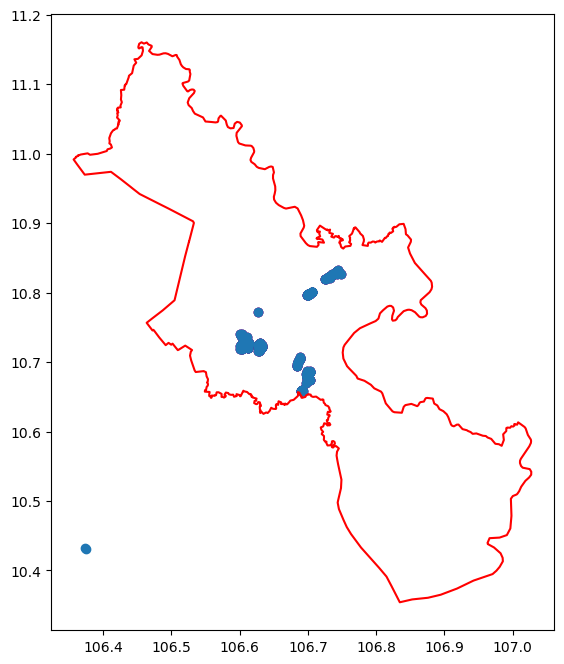

In [483]:
## drop business outside HCMC adminstrative boundary

hcmc_boundary = gpd.read_file("../input_survey_data/DEM_LiDAR/gadm36_VNM_1.shp")  # shop locations including elevation height based on original and interpolated DEM
hcmc_boundary = hcmc_boundary[hcmc_boundary.VARNAME_1 == "Ho Chi Minh"]

## clip by HCMC adminstrative boundary
all_input = gpd.GeoDataFrame(all_input, geometry=all_input.geometry)
all_input = all_input.clip(hcmc_boundary.geometry)

fig, ax = plt.subplots(figsize=(12, 8))
all_input.plot(ax=ax, color="purple")
vars_bui.geometry.plot(ax=ax)
hcmc_boundary.boundary.plot(ax=ax, color="red")
plt.show()


#### Unify monetary values

In [484]:
## check for 99
vars_money = all_input.filter(regex="_mVND", axis=1)


vars_money[vars_money.shp_capital_mVND <=1.0]
#vars_money.building_value_mVND[8] * 1000000

,shp_building_value_mVND,shp_content_value_mVND,Target_contentloss_mVND,shp_capital_mVND
216,150.0,150.0,0.0,1.0
468,150.0,150.0,0.0,1.0
4,450.0,450.0,0.0,1.0
256,450.0,450.0,0.0,1.0
139,150.0,150.0,0.0,1.0
391,150.0,150.0,0.0,1.0


In [485]:
## covnert all columns with million VND to VND
vars_money = all_input.filter(regex="_mVND", axis=1)

vars_money = np.where( (vars_money.values != np.nan),
            vars_money.values * 1000000, # convert to VND
            vars_money.values)

## rename columns
new_cols = all_input.filter(regex="_mVND", axis=1).columns.str.replace("_mVND", "_VND")
vars_money = pd.DataFrame(vars_money, columns=new_cols)


*list of all monetary vars*

- b_value_mVND	# price level for 2020 (year when survey was done)
- shp_building_value_mVND	# price level for 2020
- shp_content_value_mVND	# price level for 2020
- Target_contentloss_mVND	# price levels based on flood time
- shp_capital_mVND    # price level for 2020
- hh_monthly_income_cat  # categircal [value ranges in mVND], # price level for 2020
- shp_avgmonthly_sale_cat   # categorical [value ranges in mVND], # price level for 2020

keep categorical monetary variables unchanged (hh_monthly_income_cat, shp_avgmonthly_sale_cat) [in mVND]
All other vars are inlfation corrected based on flood time or when survey was done 
cpi_2020 = 168.8  # 2020 = year when the survey was done
   
################################################################################################################################

*Inflation correction*

adapt to direct losses to price level of 2021

Based on JRC, p.7:
The price-level update is based on global CPI information from World Bank (2015). 
Correction is performed using the following equation: 

damage2021 = damageyear_of_issue * (CPI2021 ) / (CPIyear_of_issue) 

where: 
- max_damageyear_of_issue = maximum damage in year of issue 
- max_damage2021 = maximum damage for price level 2021 
- CPIyear_of_issue = CPI for year of issue 
- CPI2020 = CPI for 2020

################################################################################################################################

*Conversion of VND to euro (or US$)*

Based on JRC, p.8 and Paprotny2018, eg.p245
The reported maximum damage values have been converted to Euro using the following exchange rates for the year 2010 (mean annual value)

Vietnam (Dong) 0.000039, for 2022 €
   - for jan-juli2023: from oanda: 0.0000393304 for €, 
    - 0.0000424798 for dollar
*Source:* 
- www.oanda.com/currency/historical-rates
-  www.ecb.europa.eu/stats/exchange/eurofxref/html/eurofxref-graph-idr.en.html

Equation: 
damage2021_euro = damage2021_vnd * avg_exchange_rate


*Further sources*
Paprotny 2018: also used country-level GDP deflators for adjusting nomnal to real losses in 2011 prices , p153, p244
Sairam 2020


In [486]:
all_input.shape

(496, 77)

*Inflation correction via GDP-deflator*

calc GDP-deflator inflation rate

inlfation rate = nominal_GDP * 100 / real_GDP 

nominal GDP : (GDP_deflator_year - real_GDP)
real GDP: GDP deflator 2020

Given that inflation is the percentage change in the overall price of an item in an economy, we can use the GDP deflator to calculate the inflation rate since its a measure of the price level.


In [551]:
data_ip2["flood_year"].isna().sum()

## TODO make sure that data_ip2.flood_year is as long as vars_money

1

In [563]:
price_index_year_of_issue = {
    2011: 121.41,
    2012: 132.44,
    2013: 137.78,
    2014: 142.88,
    2015: 140.43,
    2016: 142.98,
    2017: 149.22,
    2018: 154.63,
    2019: 158.38,
    2020: 160.70
}

price_index_2020 = 160.70
price_index_year = data_ip2["flood_year"].astype("Int64").map(price_index_year_of_issue)  # series of cpi for each year of flood event
#print(price_index_year)
exchange_rate = 1 / 27155  #  dong-> euro in 2020 (based on eurostat: https://ec.europa.eu/eurostat/databrowser/view/ERT_BIL_EUR_A/default/line?lang=en )

In [564]:
# # ### Test field with example: 223.8 new Zloty in year 1995

# # #  4.1206 = exchange rate: euro -> zloty in 2011 <-> 1/4.1206 = 0.24268 = exchange rate zloty -> euro 
# # uninflated_losses = round(( 223.8 * 0.24268), 1)  # get zloty -> euros in 2011
# # print(uninflated_losses)
# # ## price index from GDP-deflator
# # inflated_losses = uninflated_losses * 100 / 0.0000712
# # inflated_losses  # should be ~ 76 300 000 EUR in 2011

# print(vars_money.Target_contentloss_VND[0],  data_ip2["flood_year"][0])
# print("CPI inflt:", vars_money.Target_contentloss_VND_test_cpi[0])
# uninflated_losses = round((vars_money.Target_contentloss_VND[0] * exchange_rate), 1) 
# print(uninflated_losses)  #  in euro for 2020 (without inlflation) or euro 2015

# #inflated_losses = uninflated_losses * 100 / price_index_year[r]
# ## TODO check 100 = year 2020 divided by price index of year of issue is equal to my approach where 160.7 are used as refernece year instead 100
# inflated_losses = uninflated_losses * price_index_2020 / price_index_year[0]
# inflated_losses

In [567]:
## GDP-deflator

r = 0 

vars_money["Target_contentloss_VND_test_gdp"] = None

##  only direct losses needs inflation correction in respect to flood time
for r in range(len(vars_money.Target_contentloss_VND)):

    ## exchange rate: convert VND in certain year to € in the same year
    uninflated_losses = (vars_money.Target_contentloss_VND[r] * exchange_rate) # get uninflated losses in euros for year 2020
    ## price index from GDP-deflator
#    vars_money["Target_contentloss_VND_test_gdp"][r] = uninflated_losses * 100 / price_index_year[r]
    vars_money["Target_contentloss_VND_test_gdp"][r] = round(uninflated_losses * price_index_2020 / price_index_year[r], 1)


# # ##  for all other monetary continous vars: only need exchange conversion
# for c in vars_money.drop("Target_contentloss_VND", axis=1).columns:
#     for r in range(len(vars_money[c])):

#         ## convert VND_2020 to €_2020
#         vars_money[c][r] = round((vars_money[c][r]*annual_exchange_rate), 1)#.astype(int)


# ## rename columns
# new_cols = vars_money.filter(regex="_VND", axis=1).columns.str.replace("_VND", "_euro")
# vars_money.columns = new_cols


C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\3228227419.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_money["Target_contentloss_VND_test_gdp"][r] = round(uninflated_losses * price_index_2020 / price_index_year[r], 1)
C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\3228227419.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_money["Target_contentloss_VND_test_gdp"][r] = round(uninflated_losses * price_index_2020 / price_index_year[r], 1)
C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\3228227419.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

In [568]:
vars_money#.head(10)
#data_ip2 # 504

,shp_building_value_VND,shp_content_value_VND,Target_contentloss_VND,shp_capital_VND,Target_contentloss_VND_test_gdp,Target_contentloss_VND_test_cpi
0,1.000000e+09,1.000000e+09,600000.0,NaN,25.3,25.8
1,1.000000e+09,1.000000e+09,0.0,NaN,0.0,0.0
2,4.500000e+08,4.500000e+08,0.0,10000000.0,0.0,0.0
3,4.500000e+08,4.500000e+08,0.0,10000000.0,0.0,0.0
4,2.000000e+08,2.000000e+08,3200000.0,400000000.0,117.8,117.8
...,...,...,...,...,...,...
491,1.500000e+08,1.500000e+08,15000000.0,5000000.0,574.1,586.1
492,5.000000e+08,5.000000e+08,5000000.0,NaN,186.8,190.1
493,5.000000e+08,5.000000e+08,4000000.0,NaN,149.5,152.1
494,3.500000e+08,3.500000e+08,0.0,20000000.0,0.0,0.0


*Inflation correction via CPI*

In [556]:
## CPI for VND
cpi_year_of_issue = {
    2010: 100.0,
    2011: 118.7,
    2012: 129.5,
    2013: 138.0,
    2014: 143.6,
    2015: 144.6,
    2016: 148.4,
    2017: 153.6,
    2018: 159.1,
    2019: 163.5,
    2020: 168.8
}
cpi_2020 = 168.8 

#data_ip2["flood_year"] = data_ip2["flood_year"].astype("Int64")
cpi_years = data_ip2["flood_year"].astype("Int64").map(cpi_year_of_issue)  # series of cpi for each year of flood event

## exchange rate between VND and euro (in year 2020)
annual_exchange_rate = 1 / 27155  #  dong-> euro (based on eurostat: https://ec.europa.eu/eurostat/databrowser/view/ERT_BIL_EUR_A/default/line?lang=en )
print(annual_exchange_rate) #= ~ 0.0000368

print(cpi_years)

3.6825630638924695e-05
0      144.6
1      153.6
2      168.8
3      168.8
4      168.8
       ...  
499    153.6
500    153.6
501    153.6
502    163.5
503    159.1
Name: flood_year, Length: 504, dtype: float64


In [557]:
### inflation correction 

vars_money["Target_contentloss_VND_test_cpi"] = None

##  only direct losses needs inflation correction in respect to flood time
for r in range(len(vars_money.Target_contentloss_VND)):

    ## inflation correction [VND_2020]
    vars_money["Target_contentloss_VND_test_cpi"][r] = vars_money.Target_contentloss_VND[r] * cpi_2020 / cpi_years.values[r]

    ## convert VND_2020 to €_2020 [euro in 2020]
    vars_money["Target_contentloss_VND_test_cpi"][r] = round((vars_money.Target_contentloss_VND_test_cpi[r]*annual_avg_exchange_rate), 1)#.astype(int)


# # ##  for all other monetary continous vars: only need exchange conversion
# for c in vars_money.drop("Target_contentloss_VND", axis=1).columns:
#     for r in range(len(vars_money[c])):

#         ## convert VND_2020 to €_2020
#         vars_money[c][r] = round((vars_money[c][r]*annual_avg_exchange_rate), 1)#.astype(int)


# ## rename columns
# new_cols = vars_money.filter(regex="_VND", axis=1).columns.str.replace("_VND", "_euro")
# vars_money.columns = new_cols

# vars_money

C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\3116521240.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_money["Target_contentloss_VND_test_cpi"][r] = vars_money.Target_contentloss_VND[r] * cpi_2020 / cpi_years.values[r]
C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\3116521240.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vars_money["Target_contentloss_VND_test_cpi"][r] = round((vars_money.Target_contentloss_VND_test_cpi[r]*annual_avg_exchange_rate), 1)#.astype(int)
C:\Users\Anna\AppData\Local\Temp\ipykernel_9204\3116521240.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [ ]:
# update all_input with unified VND
all_input.drop(all_input.filter(regex="_mVND", axis=1).columns, axis=1, inplace=True) 
all_input = pd.concat([all_input, vars_money], axis=1)
all_input.filter(regex="euro", axis=1).columns

Index(['b_value_euro', 'shp_building_value_euro', 'shp_content_value_euro',
       'Target_contentloss_euro', 'shp_capital_euro'],
      dtype='object')

In [ ]:
all_input[all_input["shp_content_value_euro"] >= 100000.0]   
#all_input[all_input["shp_sector"] == 22].shp_content_value_euro.describe()

## fix content value for one shop with very high content value above 184 000 € (due to high building value)
## the shop is a hairsalon, median value for contents of this shop type is around 4235 €
# # id 199 no direct losses, one day closed,  - set bv , shp_bv and cv to np.nan
## cv for hairsalons [n=16]:  median: 4235 euro
all_input.loc[199,["shp_building_value_euro", "b_value_euro", "shp_content_value_euro"]] = np.nan


## Test: get information about number of stories
check amount of buildings with number of stories in HCMC by utulizing ohsome API


In [ ]:
import requests
#from ohsome import OhsomeClient
URL = 'https://api.ohsome.org/v1/elements/count'
data = {"bboxes": "106.593238,10.6971085,106.7740687,10.8401006", "format": "json", "filter": "building=* and builing!=no and building:levels=* or level=* or building:level=* or stories=* or levels=* or building:part:levels=*"}
response = requests.post(URL, data=data)
print(response.json())

## --> building tagged in HCMC: 64495.0 from those have information about stories 2746.0 --> ~ <5% stories information

In [ ]:
all_input.fiter(regex="b_material*", axis=1)
#all_input.fiter(regex="flood_time", axis=1)

## write to disk

In [ ]:
## move targets to beginning , spatial vars to end

all_input.insert(0, "Target_contentloss_euro", all_input.pop("Target_contentloss_euro"))
all_input.insert(1, "Target_businessreduction", all_input.pop("Target_businessreduction"))

all_input.insert(len(all_input.columns)-1, "elevation_m", all_input.pop("elevation_m"))
all_input.shape

(397, 88)

In [ ]:
## save to disk
all_input.to_excel("../input_survey_data/input_data_business.xlsx", index=False)

In [ ]:
## export distribution statistics 
pd.set_option('display.float_format', lambda x: '%.1f' % x)
tbl = all_input.describe().T
tbl = tbl.drop(["flood_time","id"], axis=0)
tbl.to_excel("../input_survey_data/input_data_business_distrib.xlsx", index=True)
tbl#.head(20)

In [ ]:
## flood events not merged

all_cases = pd.concat(
        [vars_dam.loc[:, vars_dam.columns != 'id'], 
        vars_bui.loc[:, vars_bui.columns != 'id'], 
        vars_soc
        ], axis=1
)
all_cases.insert(0, "Target_contentloss_mVND_r", all_cases.pop("Target_contentloss_mVND_r"))
all_cases.insert(1, "Target_contentloss_mVND_s", all_cases.pop("Target_contentloss_mVND_s"))
all_cases.insert(2, "Target_businessreduction_r", all_cases.pop("Target_businessreduction_r"))
all_cases.insert(3, "Target_businessreduction_s", all_cases.pop("Target_businessreduction_s"))
print(all_cases.shape)


## fix weird values, eg. dot instead commata
all_cases.flood_time_r = pd.to_datetime(all_cases.flood_time_r, format='mixed')
all_cases.flood_time_s = pd.to_datetime(all_cases.flood_time_s, format='mixed')
all_cases_obj = all_cases.select_dtypes(include=object)  # all obj cols

for c in all_cases_obj.columns:
    all_cases_obj[c] = drop_typos(all_cases_obj[c])
    all_cases[f"{c}"]  = all_cases_obj[f"{c}"].apply(pd.to_numeric)  # convert to int or float,  handles NAN

all_cases = all_cases.replace(99, np.nan)


## save to disk
all_cases.to_excel("../input_survey_data/input_data_business_notmerged.xlsx", index=False)


##   rests   ########

In [ ]:
all_input.shp_avgmonthly_sale_cat.describe()

In [ ]:
### damage levels
#print(all_input.filter("shpdamage_level_furniture*", axis=1).columns)
#all_input.damage_level_doors_r

#print(all_input.shpdamage_level_products.value_counts())  
#print(all_input.shpdamage_level_electronics.isna().sum())  

all_input[["shpdamage_level_furniture","shpdamage_level_equipment","shpdamage_level_electronics","shpdamage_level_products"]] = all_input[["shpdamage_level_furniture","shpdamage_level_equipment","shpdamage_level_electronics","shpdamage_level_products"]].replace(98, np.nan)
print(all_input.shpdamage_level_products.describe())  

In [ ]:
### damage levels
df_damage_levels = all_input[["shpdamage_level_furniture","shpdamage_level_equipment","shpdamage_level_electronics","shpdamage_level_products"]] 

df_damage_levels_melt = df_damage_levels.melt(value_vars=["shpdamage_level_furniture","shpdamage_level_equipment","shpdamage_level_electronics","shpdamage_level_products"])
#id_vars=
#df_damage_levels

fig, ax = plt.subplots()
#sns.barplot(x = df_damage_levels_melt["variable"], y = df_damage_levels_melt["value"])#, estimator = median)
#sns.boxplot(x=df_damage_levels_melt)#.set(title=f"{c}", xlabel=None)
sns.histplot(data=df_damage_levels, stat='count', multiple="stack")#.set(title=f"{c}", xlabel=None) # bins=12, stat="percent"

plt.xlabel("damage levels [1-no damage, 4-major damage]")#['furniture', 'equipment', 'electronics', 'products'])
plt.title("damage levels of business content")



In [ ]:
df.shpdamage_level_equipment_r.value_counts()#.sum()
#df_damage_levels.describe()# .groupby("variable")["value"]
#t = df_damage_levels.replace(1.0, np.nan)

#t = all_input.Target_businessreduction.replace(0.0, np.nan)
#t.describe()

In [ ]:
# #all_input.groupby(all_input.columns.tolist(),as_index=False).size()
# t = all_input.drop_duplicates()
# t
fig, ax = plt.subplots()

d = all_input.filter(regex="business",axis=1)
d =  drop_typos(d)  


d#.value_counts()
sns.histplot(data=d.Target_businessreduction)
#ax.set_yscale('log')
#ax.set_ylim(0,100)
#ax.set_xlim(0,100)


In [ ]:
fig, ax = plt.subplots()
d = all_input.filter(regex="Target",axis=1)
#d = d.drop(["contaminations_s.99", "contaminations_s.88"], axis=1)
#sns.histplot(bins=3, data=d, multiple="stack")
d = drop_typos(d)

sns.histplot(data=d)

#ax.set_yscale('log')
#ax.set_ylabel("")
#ax.legend(['no contamination', 'sewage water', 'fuel oil', 'chemicals', 'garbage'])

ax.set_title(f"Contamination types: \nContamination with fuel oil occures {all_input['contaminations.3'].value_counts()[1]} times")


### Distribution targets 


In [ ]:

df_targets = df[["Target_contentloss_mVND_r", "Target_contentloss_mVND_s"]]
fig, (ax_hist) = plt.subplots(len(df_targets), 2, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
#fig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
fig.suptitle('Distributions of target variables')

for i, c in enumerate(df_targets.columns[:]):
    #plt.subplots_adjust(hspace=.2)
    sns.boxplot(x=df_targets[c].astype(float), ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    sns.histplot(x=df_targets[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


## TODO : shp_closed, shp_duration_back2normal, shp_damage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


In [ ]:
fig, ax = plt.subplots()
d = all_input.filter(regex="Target",axis=1)
#d = d.drop(["contaminations_s.99", "contaminations_s.88"], axis=1)
#sns.histplot(bins=3, data=d, multiple="stack")
d = drop_typos(d)

sns.histplot(data=d)

#ax.set_yscale('log')
#ax.set_ylabel("")
#ax.legend(['no contamination', 'sewage water', 'fuel oil', 'chemicals', 'garbage'])

ax.set_title(f"Contamination types: \nContamination with fuel oil occures {all_input['contaminations.3'].value_counts()[1]} times")


In [ ]:
df_targets = df[["Target_direct_r", "Target_direct_s"]]
fig, (ax_hist) = plt.subplots(len(df_targets), 2, sharex=False, figsize=(7, 40), constrained_layout=True)#, gridspec_kw={"height_ratios": (.15, .85)})
#fig.tight_layout()  # alternative for tight_layout() and subplots_adjust(): constrained_layout=True
fig.suptitle('Distributions of target variables')

for i, c in enumerate(df_targets.columns[:]):
    #plt.subplots_adjust(hspace=.2)
    sns.boxplot(x=df_targets[c].astype(float), ax=ax_hist[i, 0]).set(title=f"{c}", xlabel=None)
    sns.histplot(x=df_targets[c].astype(float), stat='count', ax=ax_hist[i, 1]).set(title=f"{c}", xlabel=None) # bins=12, stat="percent"


## TODO : shp_closed, shp_duration_back2normal, shpdamage_level from conitnous -> intervals

# sns.despine(ax=ax_hist)  # arrange boxplots above bar charts
# sns.despine(ax=ax_box, left=True)
# ax_box.set(yticks=[])


In [ ]:
## save to disk
df_candidates_combined.to_excel("../input_survey_data/survey_data_candidates_coords.xlsx", index=False)



## TODO possible further candidates which needs to be checked and maybe developed: 
## - Indicator of flood warning information 
## - Lead time period elapsed without using it for emergency measure
## - Precautionary measure indicator
## - Knowledge of flood hazard	- as binary
## - Building quality	(Content value in USD - not in HCMC survey data, only indirect derivable via shp_sector)
## - Socioeconomic status according to Plapp [31]
##      'P1Q5.2.2':'shp_damage_level_furniture', 'P1Q5.3.2':'shp_damage_level_electronics', "shp_damage_level_others"

### Aggregate multiple choice answers

In [ ]:
df_a = df_only_numeric_vars.copy() #deep=True)

for c in col_names.values():
    #c = "contaminations_r"
    df_agg = df_only_numeric_vars.filter(regex=f'^{c}$|^{c}' + r'.*[^y]$', axis=1)  # exclude col ending with "specifcy"
    #df_agg = df_only_numeric_vars.filter(regex=f'^{c}$|^{c}' + r'|.*[^(specify)]', axis=1)  # exclude col ending with "specifcy"
    df_agg = df_agg.select_dtypes(include=np.number) # agg only numeric cols

    ##  count occurences of yes within multiple choice answers and leaves single-choice answers unchanged (e.g water_depth_cm)
    if len(df_agg.columns) >= 2:
        df_a[c] = df_agg.eq(1).sum(axis=1)
    else:
        df_a[c] = df_agg.sum(axis=1)  

## df_a contains aggregated and org columns e.g conatimnations_r.3, conatimnations_r


    #df_a[c] = df_agg.agg("max", axis="columns")  #  binary values for multile choice answers

    #print(df_a[c].head(1))
    ## TODO make nicer: .{,2}$ = matches also col.names ending with 89, 99 etc.
    #df_agg = df_only_numeric_vars.filter(regex=f'^{c}'+ r'.{,2}$|.*[^88][^99][^y]$', axis=1)  # match columns with specfied names and not containing non-numeric values
    #print(df_agg.columns.sort_values(ascending=False))#[:-1])
    #df_a[c]  =  df_a[df_agg.columns[:]].apply(lambda x: ','.join(x.dropna().astype(str)),  axis=1) # rm old cols and keep new aggregated column

    #if len(df_agg.columns) >= 1:
    #    df_a = df_a.drop(df_agg.columns.sort_values(ascending=False)[:-1], axis=1)


In [ ]:
## fix numeric variables containing integers
#df_only_numeric_vars = df_only_numeric_vars_org

df_only_numeric_vars  = df_only_numeric_vars.replace(r'^,', '', regex=True)  # fix remaining values beginning with random commas e.g. ,5
df_only_numeric_vars  = df_only_numeric_vars.replace(r' ', None, regex=True)

for c in df_only_numeric_vars.columns.drop(df_only_numeric_vars.filter(regex=f'{pattern_float_cols}|others_.$|specify$|^GPS').columns):  # exclude floats
   # df_only_numeric_vars[f"{c}"]  = df_only_numeric_vars[f"{c}"].astype(str).apply(lambda x: np.where(x.isdigit(), x, np.nan)) # set remaining errors as nan e.g 1,5
   ## df_only_numeric_vars[f"{c}"] = df_only_numeric_vars[f"{c}"].loc[:, df_only_numeric_vars.columns != 'GPS'].astype(float).astype(pd.Int64Dtype())
    df_only_numeric_vars[f"{c}"]  = df_only_numeric_vars[f"{c}"].astype(float)#.astype(pd.Int64Dtype())

## TODO fix: adds somehow more rows
#df_only_numeric_vars = pd.concat([df_only_numeric_vars, df.GPS])
#df_only_numeric_vars["GPS"] = df_only_numeric_vars[0]


In [ ]:
## set all 99 (i dont know) and 2 (didnt cost anything) to 0

pattern_int_cols = re.compile("repair_costs_building_VND_*|repair_costs_building_complete_*|repair_costs_residentail_contents_*|insurance_b*|Rank|shp_capital_mVND")
df_only_numeric_vars_99 = df_only_numeric_vars.filter(regex=re.compile(pattern_int_cols.pattern + pattern_float_cols.pattern), axis=1).replace(99, 0) 


for c in df_only_numeric_vars_99.columns:
    df_only_numeric_vars[c] = df_only_numeric_vars_99[c]  

## TODO fix float and int cells with 2 and 1, 88
## poss float cols
## INT P1.3.8 (r+s) # repair_costs_building_VND_* (2,99) = 0
# INT .311.1 +.2 # repair_costs_building_complete_* 99=0
#  INT 4.6.1 + .2 crepair_costs_damaged_contents_* ,set 99 to 0 and ,1=0
# FLOAT 5.6 target 99=0
# FLOAT P2. _spend costs P2.1.x.spend  2,99=0
# FLOAT P2Q2.4 elevation_building_material_costs 1,99=0 , keep 3,95 as FLOAT ,rest INT
# INT P2Q3.1.1 insurance_buildinge , 2+99=0
# INT P2Q3.2.1 insurance_business 2+99=0
# INT P3Q2.3 (r+s) Rank 99,88 = 0
# FLOAT P4Q2.3 building_floorsize_sqm (99=real number)
# 4.5 renov costs (r+s) ",5"-> 0.5 , 99=0
# FLOAT P5Q1.7 shp_capital_mVND, 99=0

## Create indicators
indictator for precautionary measure
- as a ratio between b measures implemented prior to the flood (nI) divided by the nb measures potentailly could have implemented (nP)
- (https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2020WR027649)
- ! check out paper from Sieg et al. (2017) - they didnt combined adapt+mitig+emerg= have more predictors

Maybe socio-economic status indicator:
- according to Plapp 2003, applied by Thieken et al 2005

indicator of warning information, 
indicator of emergency measures, 
perception of efficiency of private precaution, 
building quality, 
building/content value
